# Visual model checking
This notebook provides an example of using the stormvogel API for naive value iteration, and a way to visualize the algorithm.<br>
This algorithm takes a model and a target state. It then calculates the probability of reaching the target state from all other states iteratively. If a choice has to be made for an action, the action that gives the best result in the previous iteration is chosen.

In [1]:
import stormvogel.model

def naive_value_iteration(
    model: stormvogel.model.Model, epsilon: float, target_state: stormvogel.model.State
) -> list[list[float]]:
    """Run naive value iteration. The result is a 2D list where result[n][m] is the probability to be in state m at step n.

    Args:
        model (stormvogel.model.Model): Target model.
        steps (int): Amount of steps.
        target_state (stormvogel.model.State): Target state of the model.

    Returns:
        list[list[float]]: The result is a 2D list where result[n][m] is the value of state m at iteration n.
    """
    if epsilon <= 0:
        RuntimeError("The algorithm will not terminate if epsilon is zero.")

    # Create a dynamic matrix (list of lists) to store the result.
    values_matrix = [[0 for state in model.get_states()]]
    values_matrix[0][target_state.id] = 1

    terminate = False
    while not terminate:
        old_values = values_matrix[len(values_matrix) - 1]
        new_values = [None for state in model.get_states()]
        for sid, state in model.get_states().items():
            transitions = model.get_transitions(state)
            # Now we have to take a decision for an action.
            actions = transitions.transition.keys()
            action_values = {}
            for action, branch in transitions.transition.items():
                branch_value = sum([prob * old_values[state.id] for (prob, state) in branch.branch])
                action_values[action] = branch_value
            # We take the action with the highest value.
            highest_value = max(action_values.values())
            new_values[sid] = highest_value
        values_matrix.append(new_values)
        terminate = sum([abs(x-y) for (x, y) in zip(new_values, old_values)]) < epsilon
    return values_matrix
        

To demonstrate this, we use the lion model again.

In [2]:
from stormvogel.examples.lion import create_lion_mdp
from stormvogel.show import show
from stormvogel.layout import Layout
lion = create_lion_mdp()
vis = show(lion, layout=Layout("layouts/lion.json"))

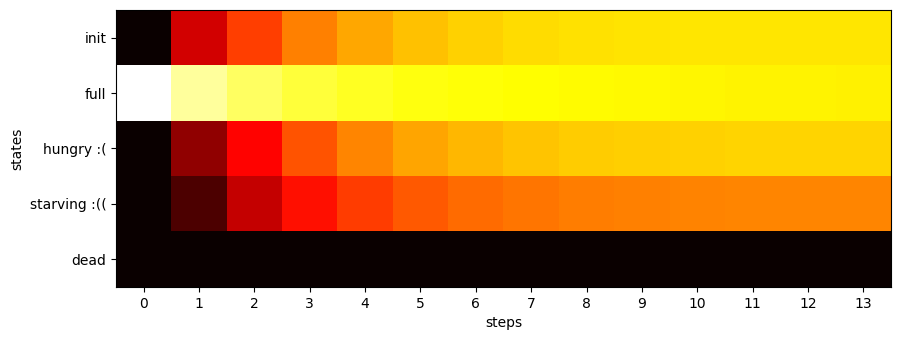

In [3]:
import stormvogel.lib

target = lion.get_states_with_label("full")[0]
res = naive_value_iteration(lion, 0.003, target)
labels = [s.labels[0] for s in lion.get_states().values()]
stormvogel.lib.display_value_iteration_result(res, 10, labels)

Note that naive_value_iteration is also available under stormvogel.lib, in case you would like to use it later. However, this implementation is very inefficient so we recommend using the value iteration algorithms from stormpy if you want good performance.

In [4]:
import stormvogel.lib
res2 = stormvogel.lib.naive_value_iteration(lion, 0.003, lion.get_states_with_label("full")[0])
assert res == res2